In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from models import ConvLSTMAttention
import random

## 1. Set Seed to Ensure Reproducibility 

In [2]:
def set_random_seed(seed):
    # Set random seed for CPU
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Set random seed for GPU if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    print(f"Random seed set to {seed}")

seed = 2023  # You can replace this with your desired seed value
set_random_seed(seed)

Random seed set to 2023


## 2. Data Preparation
* Training
    * sEMG subjects: 1-24
    * sEMG channels: 1, 2, 3, 4
    * ECG subjects: [16265, 16272, 16273, 16420, 16483, 16539, 16773, 16786, 16795, 17052, 17453, 18177] (9F+3M)
    * ECG channel: 1
    * SNR: [0, -1, -2, ..., -14, -15]
* Validation
    * sEMG subjects: 25-32
    * sEMG channels: 5, 6
    * ECG subjects: [18184, 19088, 19090, 19093, 19140, 19830] (4F+2M)
    * ECG channel: 1
    * SNR: [0, -0.5, -1, ..., -14.5, -15]
* Testing
    * sEMG subjects: 33-40
    * sEMG channels: 9, 10
    * ECG subjects: [18184, 19088, 19090, 19093, 19140, 19830] (4F+2M)
    * ECG channel: 2
    * SNR: [0, -0.5, -1, ..., -14.5, -15]

In [3]:
# Paths to annotation CSV files
train_csv_path = "train_annotations_E1.csv"
val_csv_path = "val_annotations_E1.csv"

# Folder containing .npy files
data_folder = "./mixed_signals_E1"

# Read the CSV files into pandas DataFrames
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

# Initialize lists to store data and labels
train_data = []
train_labels = []
val_data = []
val_labels = []

# Read .npy files and their corresponding SNRs
for _, row in train_df.iterrows():
    file_name = row['mixed_name']
    snr = np.array([row['snr']])
    npy_file_path = os.path.join(data_folder, file_name)
    data = np.load(npy_file_path)
    data = data.reshape(1, 10000)
    train_data.append(data)
    train_labels.append(snr)
    
for _, row in val_df.iterrows():
    file_name = row['mixed_name']
    snr = np.array([row['snr']])
    npy_file_path = os.path.join(data_folder, file_name)
    data = np.load(npy_file_path)
    data = data.reshape(1, 10000)
    val_data.append(data)
    val_labels.append(snr)

# Convert lists to NumPy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
val_data = np.array(val_data)
val_labels = np.array(val_labels)

# Print the shapes of the loaded data
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)

Train data shape: (137792, 1, 10000)
Validation data shape: (43710, 1, 10000)


In [4]:
device = 'cuda:3'
train_data = torch.Tensor(train_data).to(device)
train_labels = torch.Tensor(train_labels).to(device)
train_dataset = TensorDataset(train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_data = torch.Tensor(val_data).to(device)
val_labels = torch.Tensor(val_labels).to(device)
val_dataset = TensorDataset(val_data, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

## 3. Model, Optimizer, and Loss Function

In [5]:
criterion = nn.MSELoss()

model = ConvLSTMAttention()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)

print(model)
print("Number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

ConvLSTMAttention(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(16,), stride=(8,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(8,), stride=(4,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Number of trainable parameters:  3291793


In [6]:
import time

start = time.time()

## 4. Training Loop

In [7]:
num_epochs = 30
steps_per_print = 1000  # Print loss every 1000 steps

# Initialize a list to store the losses
train_losses = []
val_losses = []  # Initialize a list to store validation losses

best_val_loss = float('inf')  # Initialize with a high value
best_epoch = 1

for epoch in range(num_epochs):
    model.train()
    step_counter = 0  # Initialize step counter for the epoch
    epoch_loss = 0.0  # Initialize the epoch loss

    for batch_data, batch_labels in train_dataloader:
        optimizer.zero_grad()
        predictions = model(batch_data)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Accumulate the loss for the epoch

        # Increment step counter
        step_counter += 1

        # Print loss every `steps_per_print` steps
        if step_counter % steps_per_print == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step_counter}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Calculate and record the mean loss for the epoch
    mean_epoch_loss = epoch_loss / len(train_dataloader)
    train_losses.append(mean_epoch_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for val_data, val_labels in val_dataloader:
            val_predictions = model(val_data)
            val_loss += criterion(val_predictions, val_labels).item()

    mean_val_loss = val_loss / len(val_dataloader)
    val_losses.append(mean_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Mean Epoch Loss: {mean_epoch_loss:.4f}, Mean Validation Loss: {mean_val_loss:.4f}")
    print("==================================================")

    # Check if the current validation loss is the best so far
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_epoch = epoch + 1
        # Save the model's state (weights and other parameters)
        torch.save(model.state_dict(), f"./checkpoints/cnnattn_bestVal.pth")

print(f"Training completed. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
torch.save(model.state_dict(), f'./checkpoints/cnnattn_{num_epochs}eps.pth')

Epoch [1/30], Step [1000/4306], Loss: 22.6285
Epoch [1/30], Step [2000/4306], Loss: 24.2542
Epoch [1/30], Step [3000/4306], Loss: 22.0975
Epoch [1/30], Step [4000/4306], Loss: 23.5096
Epoch [1/30], Mean Epoch Loss: 23.0114, Mean Validation Loss: 26.8583
Epoch [2/30], Step [1000/4306], Loss: 2.4332
Epoch [2/30], Step [2000/4306], Loss: 3.8705
Epoch [2/30], Step [3000/4306], Loss: 1.0272
Epoch [2/30], Step [4000/4306], Loss: 2.5568
Epoch [2/30], Mean Epoch Loss: 3.2758, Mean Validation Loss: 29.7877
Epoch [3/30], Step [1000/4306], Loss: 1.0756
Epoch [3/30], Step [2000/4306], Loss: 0.5025
Epoch [3/30], Step [3000/4306], Loss: 1.0607
Epoch [3/30], Step [4000/4306], Loss: 1.6097
Epoch [3/30], Mean Epoch Loss: 1.4673, Mean Validation Loss: 38.0114
Epoch [4/30], Step [1000/4306], Loss: 1.3636
Epoch [4/30], Step [2000/4306], Loss: 2.1624
Epoch [4/30], Step [3000/4306], Loss: 1.5011
Epoch [4/30], Step [4000/4306], Loss: 0.4202
Epoch [4/30], Mean Epoch Loss: 1.1064, Mean Validation Loss: 43.0866

Epoch [28/30], Step [1000/4306], Loss: 0.2829
Epoch [28/30], Step [2000/4306], Loss: 0.1059
Epoch [28/30], Step [3000/4306], Loss: 0.3561
Epoch [28/30], Step [4000/4306], Loss: 0.3389
Epoch [28/30], Mean Epoch Loss: 0.2530, Mean Validation Loss: 76.8831
Epoch [29/30], Step [1000/4306], Loss: 0.1504
Epoch [29/30], Step [2000/4306], Loss: 0.2485
Epoch [29/30], Step [3000/4306], Loss: 0.1985
Epoch [29/30], Step [4000/4306], Loss: 0.3858
Epoch [29/30], Mean Epoch Loss: 0.2480, Mean Validation Loss: 76.7123
Epoch [30/30], Step [1000/4306], Loss: 0.2526
Epoch [30/30], Step [2000/4306], Loss: 0.4397
Epoch [30/30], Step [3000/4306], Loss: 0.2350
Epoch [30/30], Step [4000/4306], Loss: 0.0893
Epoch [30/30], Mean Epoch Loss: 0.2449, Mean Validation Loss: 77.9698
Training completed. Best validation loss: 26.8583 at epoch 1


In [8]:
end = time.time()
print(end - start)

8771.171910047531


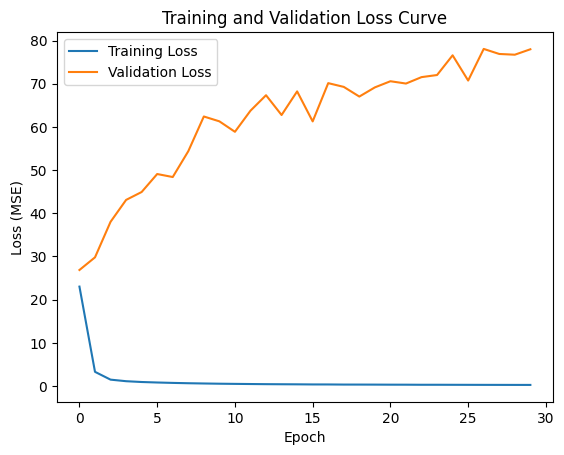

In [9]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curve')
plt.legend()  # Show legend indicating the lines
plt.show()

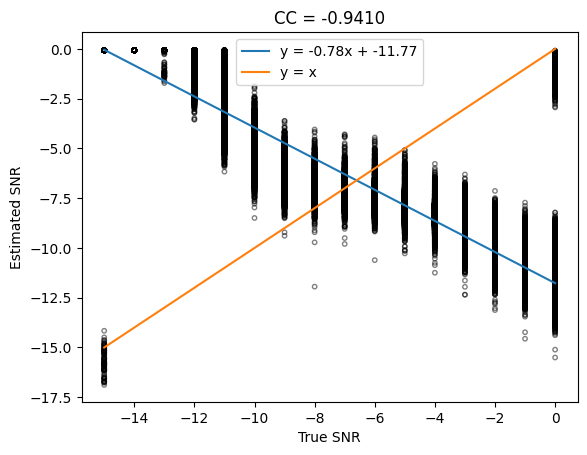

Correlation coefficient (CC): -0.9410
Spearman rank-order correlation coefficient (SRCC): -0.9556
Mean Squared Error (MSE): 71.6797


In [10]:
# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and labels
train_predictions = []
train_labels = []

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)

# Iterate through training data
with torch.no_grad():
    for batch_data, batch_labels in train_dataloader:
        predictions = model(batch_data)
        train_predictions.append(predictions.cpu())
        train_labels.append(batch_labels.cpu().numpy())

# Concatenate predictions and labels
train_predictions_np = np.concatenate(train_predictions, axis=0)
train_labels_np = np.concatenate(train_labels, axis=0)

# Reshape predictions and labels
train_predictions_flat = train_predictions_np.reshape(-1)
train_labels_flat = train_labels_np.reshape(-1)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(train_labels_flat, train_predictions_flat)

# Calculate correlation coefficients
correlation_matrix = np.corrcoef(train_labels_flat, train_predictions_flat)
correlation_coefficient = correlation_matrix[0, 1]
spearmanr_cc, _ = stats.spearmanr(train_labels_flat, train_predictions_flat)

# Plot predictions against true labels
plt.scatter(train_labels_flat, train_predictions_flat, alpha=0.5, s=10, color='none', edgecolors='black')
plt.xlabel('True SNR')
plt.ylabel('Estimated SNR')
plt.title(f'CC = {correlation_coefficient:.4f}')

# Perform linear regression
m, b = np.polyfit(train_labels_flat, train_predictions_flat, 1)
plt.plot(train_labels_flat, m * train_labels_flat + b, label=f"y = {m:.2f}x + {b:.2f}")
plt.plot(train_labels_flat, train_labels_flat, label="y = x")
plt.legend(loc='upper center')
plt.show()

# Print the results
print(f'Correlation coefficient (CC): {correlation_coefficient:.4f}')
print(f'Spearman rank-order correlation coefficient (SRCC): {spearmanr_cc:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')

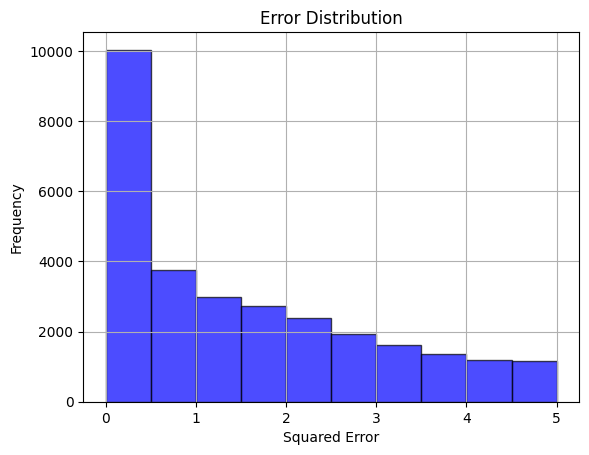

Mean Error: 71.67969
Standard Deviation of Error: 72.83758


In [11]:
# Calculate the square error for each element
error = (train_labels_flat - train_predictions_flat)**2

# Calculate mean and standard deviation of the error
mean_error = np.mean(error)
std_deviation_error = np.std(error)

# Plot the error distribution as a histogram
plt.hist(error, bins=10, alpha=0.7, color='blue', edgecolor='black', range=(0, 5))
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True)
plt.show()

print("Mean Error:", mean_error)
print("Standard Deviation of Error:", std_deviation_error)

## 5. Validation Loop

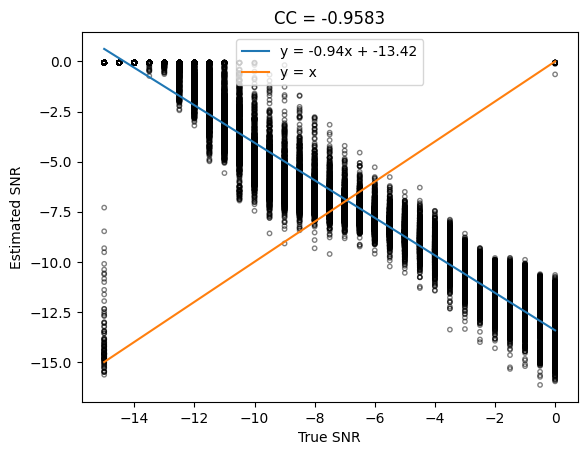

Correlation coefficient (CC): -0.9583
Spearman rank-order correlation coefficient (SRCC): -0.9584
Mean Squared Error (MSE): 77.7508


In [12]:
# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and labels
val_predictions = []
val_labels = []

# Iterate through validation data
with torch.no_grad():
    for batch_data, batch_labels in val_dataloader:
        predictions = model(batch_data)
        val_predictions.append(predictions.cpu())
        val_labels.append(batch_labels.cpu().numpy())

# Concatenate predictions and labels
val_predictions_np = np.concatenate(val_predictions, axis=0)
val_labels_np = np.concatenate(val_labels, axis=0)

# Reshape predictions and labels
val_predictions_flat = val_predictions_np.reshape(-1)
val_labels_flat = val_labels_np.reshape(-1)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(val_labels_flat, val_predictions_flat)

# Calculate correlation coefficients
correlation_matrix = np.corrcoef(val_labels_flat, val_predictions_flat)
correlation_coefficient = correlation_matrix[0, 1]
spearmanr_cc, _ = stats.spearmanr(val_labels_flat, val_predictions_flat)

# Plot predictions against true labels
plt.scatter(val_labels_flat, val_predictions_flat, alpha=0.5, s=10, color='none', edgecolors='black')
plt.xlabel('True SNR')
plt.ylabel('Estimated SNR')
plt.title(f'CC = {correlation_coefficient:.4f}')

# Perform linear regression
m, b = np.polyfit(val_labels_flat, val_predictions_flat, 1)
plt.plot(val_labels_flat, m * val_labels_flat + b, label=f"y = {m:.2f}x + {b:.2f}")
plt.plot(val_labels_flat, val_labels_flat, label="y = x")
plt.legend(loc='upper center')
plt.show()

# Print the results
print(f'Correlation coefficient (CC): {correlation_coefficient:.4f}')
print(f'Spearman rank-order correlation coefficient (SRCC): {spearmanr_cc:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')

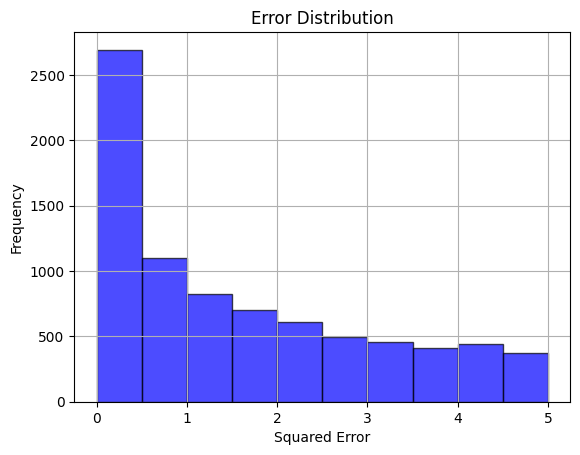

Mean Error: 77.75082
Standard Deviation of Error: 73.02799


In [13]:
# Calculate the square error for each element
error = (val_labels_flat - val_predictions_flat)**2

# Calculate mean and standard deviation of the error
mean_error = np.mean(error)
std_deviation_error = np.std(error)

# Plot the error distribution as a histogram
plt.hist(error, bins=10, alpha=0.7, color='blue', edgecolor='black', range=(0, 5))
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True)
plt.show()

print("Mean Error:", mean_error)
print("Standard Deviation of Error:", std_deviation_error)